# STOCK PREDICTION

In this script we try to perform a comparison between the two main gated units, LSTM and GRU in a stock price prediction problem.

Eric Saez Pino (204594), Josep Reverter Sancho (205571), Enrique Torres Ramos (205203)

### Data and Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2021/Project/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2021/Project/Results/'


Mounted at /content/drive


In [166]:
data = pd.read_csv(data_path + 'AMZN.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [167]:
data.shape

(5665, 7)

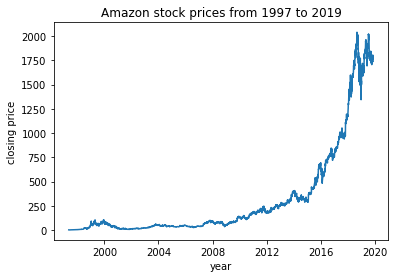

In [168]:
dates = data['Date']
values = data['Close']

# date_objects
print_dates = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
plt.plot(print_dates, values)
plt.xlabel('year')
plt.ylabel('closing price')
plt.title('Amazon stock prices from 1997 to 2019')
plt.show()

#### Data normalization

We normalize the prices to fit in -1 to 1 range by using MinMaxScaler:

In [169]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

close = data[['Close']]
close['Close'] = scaler.fit_transform(close['Close'].values.reshape(-1,1))
prices = close.iloc[1000:] # prices starting in 2001 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [170]:
prices

,Close
1000,-0.984933
1001,-0.984138
1002,-0.984766
1003,-0.985492
1004,-0.986640
...,...
5660,0.737149
5661,0.743380
5662,0.718956
5663,0.720418


#### Train and test split


In [171]:
def extract_ngrams(values, ngram_length):
    values_raw = values.to_numpy() 
    data = []
    
    # concatenating sequences (n grams)
    for index in range(len(values_raw) - ngram_length): 
        data.append(values_raw[index: index + ngram_length])
    
    data = np.array(data);

    return data

def data_split(prices, time_window):
    # extracting sequences consecutively 
    data = extract_ngrams(prices, time_window)

    test_size = int(np.round(0.2*data.shape[0]))
    train_size = data.shape[0] - (test_size)

    X_train = data[:train_size,:-1,:]
    y_train = data[:train_size,-1,:]

    X_test = data[train_size:,:-1,:]
    y_test = data[train_size:,-1,:]

    return [X_train, y_train, X_test, y_test, train_size]

ngram_length = 100 # choose time window length
x_train, y_train, x_test, y_test, train_size = data_split(prices, ngram_length)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


#y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
#y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
#y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
#y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)


### LSTM Model

In [172]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 125

#### LSTM

In [173]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out



In [174]:
import time

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    #print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Training time: 330.5683033466339


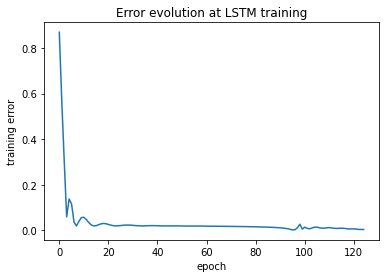

In [175]:
import math
from sklearn.metrics import mean_squared_error
plt.xlabel('epoch')
plt.ylabel('training error')
plt.title('Error evolution at LSTM training')
plt.plot(hist)
plt.savefig(results_path+'lstm_training_error.png')
plt.show()

#### LSTM Prediction

LSTM test error:  0.39143467


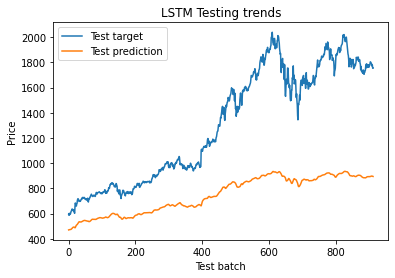

In [176]:
y_test_pred = model(x_test)

lstm_test_error = criterion(y_test_pred, y_test)
print('LSTM test error: ', lstm_test_error.detach().numpy())

lstm_test_target = scaler.inverse_transform(y_test.detach().numpy())
lstm_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())

#plt.plot(y_test)
#plt.plot(y_test_pred.detach())

plt.plot(lstm_test_target)
plt.plot(lstm_test_pred)

plt.legend(labels=['Test target', 'Test prediction'])
plt.xlabel('Test batch')
plt.ylabel('Price')
plt.title('LSTM Testing trends')
plt.savefig(results_path+'lstm_testing_trends.png')
plt.show()

###Fit at LSTM training

The model seems to overfit at training and does not generalize when predicting from the test set. 
This could be due to the sequence variance is lower at training, so that at testing the model is predicting with parameters fitted to low prices fluctuation and does not expect the abrupt increase of stock prices in the test set. 

LSTM train error:  0.0028392393


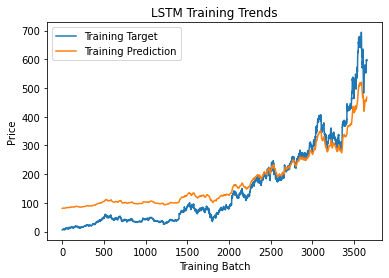

In [177]:
y_train_pred = model(x_train)

lstm_train_error = criterion(y_train_pred, y_train)
print('LSTM train error: ', lstm_train_error.detach().numpy())

lstm_train_target = scaler.inverse_transform(y_train.detach().numpy())
lstm_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())

plt.plot(lstm_train_target)
plt.plot(lstm_train_pred)

plt.legend(labels=['Training Target', 'Training Prediction'])
plt.xlabel('Training Batch')
plt.ylabel('Price')
plt.title('LSTM Training Trends')
plt.savefig(results_path+'lstm_training_trends.png')
plt.show()

Overall prediction error:  0.08055832237005234


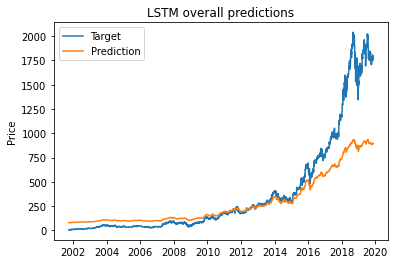

In [178]:
lstm1 = np.concatenate([lstm_train_target,lstm_test_target])
pred = np.concatenate([lstm_train_pred, lstm_test_pred])

overall_lstm_error = criterion(torch.cat((y_train_pred, y_test_pred),0), torch.cat((y_train, y_test),0))
print('Overall prediction error: ',overall_lstm_error.item())

date_objects = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dates.iloc[1100:]]

plt.plot(date_objects,lstm1)

plt.plot(date_objects,pred)
plt.legend(labels=['Target', 'Prediction'])
plt.ylabel('Price')
plt.title('LSTM overall predictions')
plt.savefig(results_path+'lstm_overall_trends.png')
plt.show()


#### GRU

In [179]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [180]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [181]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    #print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Training time: 194.03824734687805


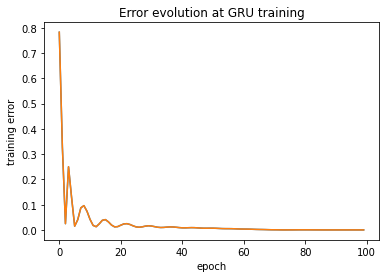

In [182]:
import math
from sklearn.metrics import mean_squared_error
plt.plot(hist)
plt.xlabel('epoch')
plt.ylabel('training error')


plt.title('Error evolution at GRU training')
plt.plot(hist)
plt.savefig(results_path+'gru_training_error.png')
plt.show()

#### GRU Prediction

GRU test error:  0.0021358947


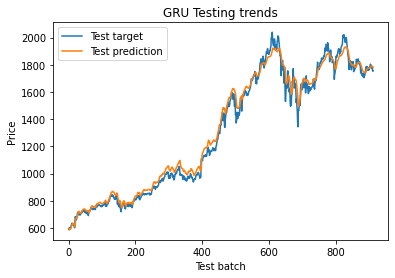

In [184]:
y_gru_test_pred = model(x_test)

gru_test_error = criterion(y_gru_test_pred, y_test)
print('GRU test error: ', gru_test_error.detach().numpy())

gru_test_target = scaler.inverse_transform(y_test.detach().numpy())
gru_test_pred = scaler.inverse_transform(y_gru_test_pred.detach().numpy())

#plt.plot(y_test)
#plt.plot(y_test_pred.detach())

plt.plot(gru_test_target)
plt.plot(gru_test_pred)

plt.legend(labels=['Test target', 'Test prediction'])
plt.xlabel('Test batch')
plt.ylabel('Price')
plt.title('GRU Testing trends')
plt.savefig(results_path+'gru_testing_trends.png')
plt.show()

#### GRU fit at training

LSTM train error:  0.000113340095


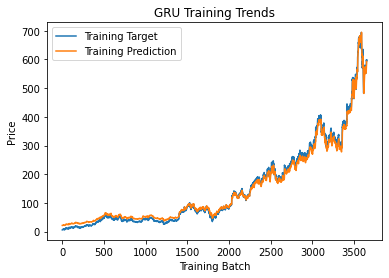

In [185]:
y_gru_train_pred = model(x_train)

gru_train_error = criterion(y_gru_train_pred, y_train)
print('LSTM train error: ', gru_train_error.detach().numpy())

gru_train_target = scaler.inverse_transform(y_train.detach().numpy())
gru_train_pred = scaler.inverse_transform(y_gru_train_pred.detach().numpy())

plt.plot(gru_train_target)
plt.plot(gru_train_pred)

plt.legend(labels=['Training Target', 'Training Prediction'])
plt.xlabel('Training Batch')
plt.ylabel('Price')
plt.title('GRU Training Trends')
plt.savefig(results_path+'gru_training_trends.png')
plt.show()

#### GRU overall prediction

Overall prediction error:  0.0005178509745746851


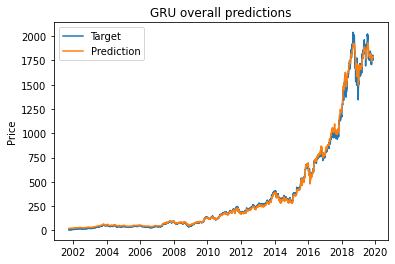

In [186]:
gru1 = np.concatenate([gru_train_target,gru_test_target])
gru_pred = np.concatenate([gru_train_pred, gru_test_pred])

overall_gru_error = criterion(torch.cat((y_gru_train_pred, y_gru_test_pred),0), torch.cat((y_train, y_test),0))
print('Overall prediction error: ',overall_gru_error.item())

date_objects = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dates.iloc[1100:]]

plt.plot(date_objects,gru1)

plt.plot(date_objects,gru_pred)
plt.legend(labels=['Target', 'Prediction'])
plt.ylabel('Price')
plt.title('GRU overall predictions')
plt.savefig(results_path+'gru_overall_trends.png')
plt.show()